In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [56]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

In [2]:
# Task 1: fit models to interest rate 01.01.1962 - 22.12.2022
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

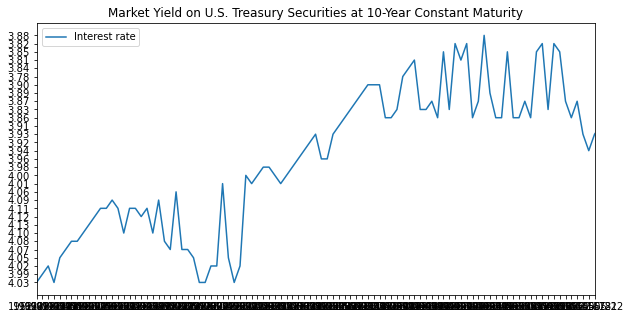

In [3]:
# Plot 
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_IR['DATE'][1:100], df_IR['DGS10'][1:100], label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim((df_IR['DATE'][1],df_IR['DATE'][100]))
plt.legend()
plt.show()

In [4]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [63]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.72740515607
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [0.02820138 1.03352921]
Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.8834347341
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4245.15216005611
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e+00, constraint violation: 0.00e+00, execution time:  3.2 s.
Final Params: [0.01107014 

In [65]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -39975.989 - BrownianMotion model with params [0.02820138 1.03352921],
       -41606.776 - CEV model with params [0.02011782 0.13874663 0.567096   0.33594728],
       -41068.090 - CIR model with params [0.01107014 0.01003217 0.43970139],
       -33861.192 - GeometricBM model with params [0.01417254 0.24199875],
       -33890.454 - IGBM model with params [0.08735432 8.25039156 0.24173694],
       -39974.495 - OrnsteinUhlenbeck model with params [0.01460372 0.37797492 1.03350969],
       -41605.408 - CKLS model with params [0.0859749  0.02823561 0.57802181 0.32404685],
       
The best model is CEV     with param [0.02011782 0.13874663 0.567096   0.33594728]


In [57]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.69 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9430041102
`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  6.8 s.
Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]
Final Likelihood: 20808.48690558895
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.905730253681


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  3.5 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`xtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 72, CG iterations: 41, optimality: 1.31e-03, constraint violation: 0.00e+00, execution time: 0.33 s.
Final Params: [0.02983373 0.24229504]
Final Likelihood: 16937.439592289964
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34107098833
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756
Initial Params: [0.01, 0.01, 0.2]


In [66]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -39976.040 - BrownianMotion model with params [0.01020195 1.03352475],
       -41608.974 - CEV model with params [0.01190742 0.6541825  0.57703004 0.32514395],
       -41070.708 - CIR model with params [0.06796725 5.63695691 0.43988463],
       -33870.879 - GeometricBM model with params [0.02983373 0.24229504],
       -33889.449 - IGBM model with params [0.14484645 5.02723773 0.24221546],
       -39974.493 - OrnsteinUhlenbeck model with params [0.0153225  0.38192952 1.03354022],
       -41608.424 - CKLS model with params [0.02275114 0.01000081 0.57692629 0.32523876],
       
The best model is CEV     with param [0.01190742 0.6541825  0.57703004 0.32514395]


In [61]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"] 

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  0.5 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.8 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Pa

In [67]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -39976.040 - BrownianMotion model with params [0.01020182 1.03352475],
       -41611.492 - CEV model with params [0.06504598 5.87897445 0.57674668 0.32538039],
       -41070.711 - CIR model with params [0.0665169  5.73914592 0.43982522],
       -33870.879 - GeometricBM model with params [0.02963357 0.2423094 ],
       -33889.449 - IGBM model with params [0.14456926 5.03477519 0.24214574],
       -39975.780 - OrnsteinUhlenbeck model with params [0.0584254  5.79871441 1.03346573],
       -41608.424 - CKLS model with params [0.02266262 0.01000016 0.57693789 0.32523859],
       
The best model is CEV     with param [0.06504598 5.87897445 0.57674668 0.32538039]


In [70]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.02011782 0.13874663 0.567096   0.33594728],
     [0.01190742 0.6541825  0.57703004 0.32514395],
     [0.06504598 5.87897445 0.57674668 0.32538039]


In [13]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()] 

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.9 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Pa

/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.9 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 304, CG iterations: 155, optimality: 1.41e-03, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.08770393 5.78358701 0.43976036]
Final Likelihood: 20539.58144890376
Initial Params: [0.01, 0.2]
In

`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.85 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.92 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.

100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.90s/it]

`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  2.1 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


In [12]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()] 

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [7]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]Initial Params: [0.01, 0.2]Initial Params: [0.01, 0.2]Initial Params: [0.01, 0.2]Initial Params: [0.01, 0.2]Initial Params: [0.01, 0.2]
Initial Params: [0.01, 0.2]


Initial Params: [0.01, 0.2]



Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861

Initial Likelihood: -97580.7274044861



Initial Likelihood: -97580.7274044861



  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861

  0%|                                                   | 0/100 [00:00<?, ?it/s]


Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256`xtol` termination condition is satisfied.

Initial Params: [0.01, 0.01, 0.01, 0.2]Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.65 s.

Final Params: [0.01020182 1.03352475]Initial Likelihood: -882056.4885660926

Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.3 s.

Number of iterations: 82, function evaluations: 425, CG iterations: 220

/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176
Initial Params: [0.01, 0.2]


/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.79 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  0.8 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
`xtol` termination condition is satisfied.Initial Likelihood: -882056.4885660926

Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.68 s.Initial Params: [0.01, 0.2]

Final Params: [0.0584254  5.79871441 1.03346573]Initial Likelihood: -97580.7274044861
Final Likelihood: 19990.88982877334

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.71 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.77 s.`xtol` termination condition is satisfied.

Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.01020182 1.03352475]Final Params: [0.0207732  1.93377064 1.03352596]
Final Likelihood: 19990.02019661256

Final Likelihood: 19990.298032206352Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Params: [0.01, 0.01, 0.01, 0.2]Initial Likelihood: -882056.4885660926

Initial Likelihood: -881970.1768382159`xtol` termination condition is satisfied.

Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.0207732  1.93377064 1.03352596]
Final Likelihood: 19990.298032206352
Initial Params:

/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176
Initial Params: [0.01, 0.2]


/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
F

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]

Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861



  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.86 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.87 s.
Final Params: [0.02963357 0.2423094 ]
`xtol` termination condition is satisfied.Final Likelihood: 16937.439613307815

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693Final Params: [0.01020182 1.03352475]Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  1.2 s.


Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial

/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 304, CG iterations: 155, optimality: 1.41e-03, constraint violation: 0.00e+00, execution time:  2.5 s.
Final Params: [0.08770393 5.78358701 0.43976036]
Final Likelihood: 20539.58144890376
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866293194
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
`gtol` termination condition is satisfied.Initial Params: [0.01, 0.2]

Initial Likelihood: 16395.539569657703`xtol` termination condition is satisfied.Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.51 s.

`xtol` termination condition is satisfied.
Number

/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x



Final Params: [0.02983373 0.24229504]Final Likelihood: 16937.439592289964
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: nan

Final Params: [0.0207732  1.93377064 1.03352596]Final Likelihood: 16937.439592289964


Initial Params: [0.01, 0.01, 0.2]Initial Likelihood: 16394.34107098833Final Likelihood: 19990.298032206352
Initial Likelihood: 16394.34107098833


Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881970.1768382159
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176
Initial Params: [0.01, 0.2]


/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  2.8 s.
Final Params: [0.0207732  1.93377064 1.03352596]
Final Likelihood: 19990.298032206352
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881970.1768382159
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  2.0 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176
Initial Params: [0.01, 0.2]


/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py:106: RuntimeWarning: invalid value encountered in true_divide
  temp = mu * (np.exp(mu_x * t) - 1) / mu_x


Initial Likelihood: nan
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.04114658969
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.04114658969
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  4.4 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood:

Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  2.0 s.Final Likelihood: 19989.994410663072

Final Params: [0.02820138 1.03352921]
Initial Params: [0.01, 0.01, 0.01, 0.2]Final Likelihood: 19989.994410663072

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.8834347341Initial Likelihood: -882056.8834347341

`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 304, CG iterations: 155, optimality: 1.41e-03, constraint violation: 0.00e+00, execution time:  2.0 s.
Final Params: [0.08770393 5.78358701 0.43976036]
Final Likelihood: 20539.58144890376
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866293194
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 304, CG iterations: 155, optimality: 1.41e-03, constraint violation: 0.00e+00, execution time:  2.0 s.
Final Params: [0.08770393 5.78358701 0.

Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.9 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4245.15216005611
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  7.1 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425`gtol` termination condition is satisfied.

Initial Params: [0.01, 0.01, 0.2]`xtol` termination condition is satisfied.Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.53 s.

Final Params: [0.01020195 1.03352475]Initial Likelihood: 4245.15216005611

Final Likelihood: 19990.02019649387

Initial 

Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.02820138 1.03352921]
Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.8834347341
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.02820138 1.03352921]
Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.8834347341
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.0411465

Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e+00, constraint violation: 0.00e+00, execution time: 0.77 s.
Final Params: [0.01107014 0.01003217 0.43970139]
Final Likelihood: 20537.04494102944
Initial Params: [0.01, 0.2]
Initial Likelihood: 16396.54725556157
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.44 s.
Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`xtol` termination condition is satisfied.
Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time:  9.7 s.
Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]
Final Likelihood: 20806.7041020897
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xt

Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.44 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.92 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e+00, constraint violation: 0.00e+00, execution time: 0.87 s.
Final Params: [0.01107014 0.01003217 0.43970139]
Final Likelihood: 20537.04494102944
Initial Params: [0.01, 0.2]
Initial Likelihood: 16396.54725556157
`gtol` te

  1%|▍                                        | 1/100 [01:06<1:49:48, 66.55s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 220, CG iterations: 124, optimality: 1.34e-02, constraint violation: 0.00e+00, execution time:  1.1 s.
`gtol` termination condition is satisfied.
Final Params: [0.01460372 0.37797492 1.03350969]Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.5 s.`xtol` termination condition is satisfied.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]

Final Likelihood: 19990.247571391323Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.4 s.


Final Params: [0.02011782 0.13874663 0.567096   0.33594728]Initial Params: [0.01, 0.01, 0.01, 0.2]

Final Likelihood: 20808.212239674176Final Likelihood: 20807.388196466425



  1%|▍                                        | 1/100 [01:06<1:50:30, 66.97s/it]

Initial Params: [0.01, 0.01, 0.2]Initial Params: [0.01, 0.2]
Initial Likelihood: -881975.4381758212

Initial Likelihood: -97580.7274044861Initial Likelihood: 4245.15216005611

`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.73 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e

Initial Likelihood: 16394.461404180693
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.78 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.91 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 220, CG iterations: 124, optimality: 1.34e-02, constraint violation: 0.00e+00, execution time:  1.3 s.

Number of iterations: 52, fu

Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  1%|▍                                        | 1/100 [01:11<1:58:00, 71.52s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.56 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01

  1%|▍                                        | 1/100 [01:12<1:59:27, 72.40s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.4 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.55 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.3 s.
Final Params: [0.07263466 5.97

Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.03191521099
`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.83 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991


  1%|▍                                        | 1/100 [01:13<2:01:17, 73.51s/it]

Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.0 s.
Initial Params: [0.01, 0.2]
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]Initial Likelihood: -97580.7274044861

Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.2 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.81 s.
Final Params: [0.14456926 5.03477519 0.24214574]`gtol` t

Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.88 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176`xtol` termination condition is satisfied.



  1%|▍                                        | 1/100 [01:12<2:00:19, 72.93s/it]

Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.2 s.
Initial Params: [0.01, 0.2]
Final Params: [0.0665169  5.73914592 0.43982522]Initial Likelihood: -97580.7274044861

Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.8 s.Initial Params: [0.01, 0.01, 0.01, 0.2]
Final Params: [0.01 0.2 ]

Final Likelihood: nan
Initial Likelihood: -882061.9430041102Initial Params: [0.01, 0.01, 0.01, 0.

  1%|▍                                        | 1/100 [01:14<2:02:46, 74.41s/it]



Initial Params: [0.01, 0.2]
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.5 s.Initial Likelihood: -97582.8495587991

Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]Initial Likelihood: -97580.7274044861

Final Likelihood: 20808.212239674176


  1%|▍                                        | 1/100 [01:14<2:02:51, 74.46s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.56 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.57 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.88 s.
Final Params: [0.0584254  5.79871441 1.03346573]

Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.84 s.
Final Params: [0.14456926 5.03477519 0.24214574]`gtol` termination condition is satisfied.

Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  0.9 s.Final Likelihood: 16947.72429211084

Final Params: [0.14456926 5.03477519 0.24214574]Initial Params: [0.01, 0.01, 0.2]
Final Likelihood: 16947.72429211084

Initial Likelihood: -97582.8495587991Initial Params: [0.01, 0.01, 0.2]

Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time: 0.62 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34259632613
`xtol

Initial Likelihood: -882061.9333392687Final Likelihood: nan

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.0153225  0.38192952 1.03354022]
Final Likelihood: 19990.246407590013
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881971.1034713375
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]`xtol` termination condition is satisfied.

Initial Likelihood: 16394.34259632613Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00

Initial Likelihood: 16394.34259632613
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.03191521099
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9430041102
`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  4.9 s.
Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]
Final Lik

Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e+00, constraint violation: 0.00e+00, execution time: 0.88 s.Final Params: [0.0153225  0.38192952 1.03354022]

Final Likelihood: 19990.246407590013Final Params: [0.01107014 0.01003217 0.43970139]

Initial Params: [0.01, 0.01, 0.01, 0.2]
Final Likelihood: 20537.04494102944Initial Likelihood: -881971.1034713375`xtol` termination condition is satisfied.
Initial Params: [0.01, 0.2]


Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.45 s.Initial Likelihood: 16396.54725556157

Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.74 s.
Fi

Initial Likelihood: 16394.34107098833
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.8 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706`xtol` termination condition is satisfied.

Initial Params: [0.01, 0.2]Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.6 s.
Final Params: [0.06796725 5.63695691 0.43988463]

Initial Likelihood: 16395.659866285718
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.`xtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 72, CG iterations: 41, optimality: 1.31e-03, constraint violation: 0.00e+00, execution tim

Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.6 s.
Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.7 s.Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]

Final Likelihood: 20808.212204603646
Initial Params: [0.01, 0.2]Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]

Final Likelihood: 20808.212204603646
Initial Likelihood: -97580.72740515607Initial Params: [0.01, 0.2]

Initial Likelihood: -97580

Initial Params: [0.01, 0.01, 0.2]Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]

Final Likelihood: 20808.212239674176
Initial Likelihood: -97582.84719595249

  2%|▊                                        | 2/100 [02:14<1:49:52, 67.27s/it]


Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  2%|▊                                        | 2/100 [02:15<1:50:32, 67.68s/it]

`xtol` termination condition is satisfied.Initial Params: [0.01, 0.2]

Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.78 s.Initial Likelihood: -97580.7274044861

Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.2 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
`xtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.2]

Number of iterations: 52, function evaluations: 220, CG iterations: 124, optimality: 1.34e-02, constraint violation: 0.00e+00, execution time:  1.3 s.
Initial Likelihood: 4245.15216005611
Final Params: [0.01460372 0.377

Number of iterations: 53, function evaluations: 180, CG iterations: 99, optimality: 2.60e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.08735432 8.25039156 0.24173694]
Final Likelihood: 16948.227143979035
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.84719595249
`xtol` termination condition is satisfied.
Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]
Final Likelihood: 20806.7041020897
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 

Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.57 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.97 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  2%|▊                                        | 2/100 [02:21<1:54:57, 70.38s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  2%|▊                                        | 2/100 [02:21<1:55:13, 70.55s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295`xtol` termination condition is satisfied.

Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.61 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.0 s.
Final Params: [0.07263466 5.9

`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.65 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01

  2%|▊                                        | 2/100 [02:22<1:56:06, 71.09s/it]

Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Initial Params: [0.01, 0.2]Final Likelihood: 20538.355475842895

Initial Params: [0.01, 0.2]Initial Likelihood: -97580.7274044861

Initial Likelihood: 16395.539569657703
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.92 s.
Final Params: [0.14456926 5.03477519 0.24214574]`gtol` termination condition is satisfied.

Final Likelihood: 16947.72429211084Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.37 s.

Initial Params: [0.01, 0.01, 0.2]Final Params: [0.02963357 0.2423094 ]

Final Likelihood: 16937.439613307815Initial Likelihood: -97582.8495587991

Initial Param

`gtol` termination condition is satisfied.The maximum number of function evaluations is exceeded.

Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.8 s.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.81 s.Final Params: [0.01 0.2 ]

Final Params: [0.14456926 5.03477519 0.24214574]Final Likelihood: nan

Initial Params: [0.01, 0.01, 0.01, 0.2]
Final Likelihood: 16947.72429211084Initial Likelihood: -882061.9333392687

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  2%|▊                                        | 2/100 [02:22<1:56:09, 71.12s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.56 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
`gtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -882061.9430041102Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.35 s.

Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 1

  2%|▊                                        | 2/100 [02:25<1:58:02, 72.27s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  2%|▊                                        | 2/100 [02:25<1:58:14, 72.40s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.0 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.56 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.3 s.`xtol` termination condition i

Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.7 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.89 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol

Final Params: [0.0153225  0.38192952 1.03354022]
Final Likelihood: 19990.246407590013
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881971.1034713375
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9430041102
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  2.0 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optim

Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866293194
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34259632613
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time: 0.76 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34259632613
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.0207732  1.93377064 1.03352596]
Final Likeliho

Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`xtol` termination condition is satisfied.`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00e+00, execution time:  1.7 s.
Number of iterations: 53, function evaluations: 180, CG iterations: 99, optimality: 2.60e-01, constraint violation: 0.00e+00, execution time: 0.97 s.

Final Params: [0.08735432 8.25039156 0.24173694]Final Params: [0.0153225  0.38192952 1.03354022]
Final Likelihood: 19990.246407590013
Final Likelihood: 16948.227143979035

`xtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Params: [0.01, 0.01, 0.2]

Number of iterations: 66, f

Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.04114658969
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.5 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`xtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 72, CG iterations: 41, optimality: 1.31e-03, constraint violation: 0.00e+00, execution time: 0.34 s.
Final Params: [0.02983373 0.24229504]
Final Likelihood: 16937.439592289964
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34107098833
`xto

Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.02820138 1.03352921]
Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]
`xtol` termination condition is satisfied.Initial Likelihood: -882056.8834347341
Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.2 s.

Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]
Final Likelihood: 20808.212204603646
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.727405156

Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  3%|█▏                                       | 3/100 [03:24<1:50:48, 68.54s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.5 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4245.15216005611
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  3%|█▏                                       | 3/100 [03:24<1:50:52, 68.58s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.61 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 192, CG iterations: 34, optimality: 9.88e+00, constraint violation: 0.00e+00, execution time: 0.82 s.
Final Params: [0.01107014 0.01003217 0.43970139]
Final Likelihood: 20537.04494102944
Initial Params: [0.01, 0.2]
Initial Likelihood: 16396.54725556157
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.61 s.
Final Params: [0.01020182 1.03352475]
Final Likelih

Number of iterations: 52, function evaluations: 220, CG iterations: 124, optimality: 1.34e-02, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.01460372 0.37797492 1.03350969]
Final Likelihood: 19990.247571391323
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881975.4381758212
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  0.8 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.01020182 1.03352475]

Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0

  3%|█▏                                       | 3/100 [03:26<1:50:06, 68.11s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  2.1 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.71 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Par

  3%|█▏                                       | 3/100 [03:30<1:53:00, 69.90s/it]

Initial Params: [0.01, 0.2]

Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]Initial Likelihood: -97580.7274044861Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.


Final Likelihood: 20810.11012414479Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]
Initial Params: [0.01, 0.01, 0.2]

Initial Likelihood: 4236.909259449505Final Likelihood: 20806.7041020897

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  0.8 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG 

  3%|█▏                                       | 3/100 [03:30<1:52:01, 69.29s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.92 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]
Final Likelihood: 20806.7041020897
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.57 s.
Final Params: [0.01020182 

Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.86 s.
Final Likelihood: nanFinal Params: [0.0584254  5.79871441 1.03346573]

Initial Params: [0.01, 0.01, 0.01, 0.2]Final Likelihood: 19990.88982877334

Initial Likelihood: -882061.9333392687
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703
`xtol` termination condition is satisfied.
`gtol` termination condition is satisfied.Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.1 s.



  3%|█▏                                       | 3/100 [03:30<1:52:32, 69.62s/it]



Initial Params: [0.01, 0.2]Final Params: [0.14456926 5.03477519 0.24214574]Final Likelihood: 20808.212239674176

Final Likelihood: 16947.72429211084Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861

Initial Params: [0.01, 0.01, 0.2]Initial Likelihood: nan


Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  2.2 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time:  0.5 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -88

  3%|█▏                                       | 3/100 [03:31<1:52:26, 69.55s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time:  0.9 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.62 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.0584254  5.79871441

  3%|█▏                                       | 3/100 [03:33<1:54:05, 70.57s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926`xtol` termination condition is satisfied.

Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.2 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]`xtol` termination condition is satisfied.

Final Likelihood: 20809.746119226467Number of iterations: 74, function evaluations: 304, CG iterations: 155, optimality: 1.41e-03, constraint violation: 0.00e+00, execution time:  1.7 s.

Final Params: [0.08770393 5.78358701 0.43976036]
Final Likelihood: 20539.58144890376Initial Params: [0.

Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.1 s.
Initial Likelihood: 16394.34259632613

Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.4 s.`xtol` termination condition is satisfied.

Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]Number of iterations: 26, function evaluations

Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.0 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution

`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  5.1 s.
Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]
Final Likelihood: 20808.48690558895`xtol` termination condition is satisfied.
Initial Params: [0.01, 0.01, 0.2]

Initial Likelihood: 4236.905730253681Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  2.1 s.

Final Params: [0.0207732  1.93377064 1.03352596]
Final Likelihood: 19990.298032206352
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881970.1768382159
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.68954002516

Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.8 s.
Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]
Final Likelihood: 20808.212204603646
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.72740515607
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.01020195 1.03352475]`xtol` termination condition is satisfied.
Final Likelihood: 19990.02019649387

Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.9 s.Initial Params: [0.01, 0.01, 0.01, 0.2]

Final Params: [0.06796725 5.63695691 0.43988463]Initial Likelihood: -882061.9430041102

Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.65986

Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.14484645 5.02723773 0.24221546]
Final Likelihood: 16947.72426858756`xtol` termination condition is satisfied.
Initial Params: [0.01, 0.01, 0.2]

Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.5 s.Initial Likelihood: -97587.04114658969

Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
`xtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.2]
Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  1.7 s.

Final Params: [0.02820138 1.03352921]
Initial Likelihood: 4245.15216005611Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood:

`xtol` termination condition is satisfied.Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  2.0 s.

Final Params: [0.02820138 1.03352921]Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.9 s.

Final Likelihood: 19989.994410663072Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]

Final Likelihood: 20808.212204603646Initial Params: [0.01, 0.01, 0.01, 0.2]
`xtol` termination condition is satisfied.

Initial Params: [0.01, 0.2]
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.4 s.
Initial Likelihood: -97580.72740515607Initial Likelihood: -882056.8834347341Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]


Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Like

  4%|█▋                                       | 4/100 [04:33<1:49:52, 68.67s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176`xtol` termination condition is satisfied.



  4%|█▋                                       | 4/100 [04:33<1:49:50, 68.66s/it]

Initial Params: [0.01, 0.2]
Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  7.3 s.
Initial Likelihood: -97580.7274044861Final Params: [0.02011782 0.13874663 0.567096   0.33594728]

Final Likelihood: 20807.388196466425
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4245.15216005611
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.78 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926`xtol` termination condition is satisfied.

Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.8 s.
`xtol` termination condition is satisfied.Final Params: [0.02011782 0.138

Final Likelihood: 20806.7041020897Number of iterations: 53, function evaluations: 180, CG iterations: 99, optimality: 2.60e-01, constraint violation: 0.00e+00, execution time:  1.0 s.

Final Params: [0.08735432 8.25039156 0.24173694]
Final Likelihood: 16948.227143979035Initial Params: [0.01, 0.2]
`gtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.2]

Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.85 s.

Final Params: [0.14456926 5.03477519 0.24214574]Initial Likelihood: -97582.84719595249Initial Likelihood: -97580.7274044861


Final Likelihood: 16947.72429211084`gtol` termination condition is satisfied.

Initial Params: [0.01, 0.01, 0.2]Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.84 s.

Initial Likelihood: -97582.8495587991
Final Params: [0.14456926 5.03477519 0.24214574

Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.88 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  2.2 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.1 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0

  4%|█▋                                       | 4/100 [04:39<1:52:01, 70.02s/it]

Initial Params: [0.01, 0.2]Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895

Initial Likelihood: -97580.7274044861`xtol` termination condition is satisfied.
Initial Params: [0.01, 0.2]

Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  3.4 s.Initial Likelihood: 16395.539569657703

Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  4%|█▋                                       | 4/100 [04:39<1:51:12, 69.50s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
`gtol` termination condition is satisfied.Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]

Final Likelihood: 20806.7041020897
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.44 s.Initial Params: [0.01, 0.2]

Initial Likelihood: -97580.7274044861Final Params: [0.02963357 0.2423094 ]

Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.01020182 1.03352475]
Final 

  4%|█▋                                       | 4/100 [04:39<1:51:05, 69.43s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.03191521099
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703
`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.37 s.
Final Params: [0.02963357 0.2423094 ]
Fina

Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.`gtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  1.3 s.`xtol` termination condition is satisfied.
Final Params: [0.0665169  5.73914592 0.43982522]

Final Likelihood: 20538.355475842895Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.6 s.


Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  2.3 s.Initial Params: [0.

  4%|█▋                                       | 4/100 [04:40<1:51:18, 69.56s/it]

`gtol` termination condition is satisfied.Initial Params: [0.01, 0.2]
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.65 s.

Initial Likelihood: -97580.7274044861
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9430041102
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  4%|█▋                                       | 4/100 [04:40<1:51:02, 69.40s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.55 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]`gtol` termination condition is satisfied.

Initial Likelihood: -882056.4885660926
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.84 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.8495587991
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.0584254  5.79871441 1.03346

  4%|█▋                                       | 4/100 [04:42<1:51:48, 69.88s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.54 s.
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.8 s.Final Params: [0.01020182 1.03352475]

Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]Final Likelihood: 19990.02019661256

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial L

Number of iterations: 38, function evaluations: 87, CG iterations: 51, optimality: 1.86e-05, constraint violation: 0.00e+00, execution time:  0.7 s.
Final Params: [0.02963322 0.24229516]
Final Likelihood: 16937.43961330653
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.34259632613
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.6 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.7 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`gtol` te

Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.20210607 4.79290687 0.24200481]
`xtol` termination condition is satisfied.
Final Likelihood: 16955.689540025167
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  2.0 s.Initial Params: [0.01, 0.01, 0.2]

Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]Initial Likelihood: -97587.03191521099
Final Likelihood: 20808.237611879857

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.

`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  4.5 s.`xtol` termination condition is satisfied.

Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  4.7 s.

Final Likelihood: 20808.48690558895Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]

Initial Params: [0.01, 0.01, 0.2]Final Likelihood: 20808.48690558895

Initial Params: [0.01, 0.01, 0.2]Initial Likelihood: 4236.905730253681

Initial Likelihood: 4236.905730253681
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.0207732  1.93377064 1.03352596]
Final Likelihood: 19990.2980322

Number of iterations: 27, function evaluations: 93, CG iterations: 36, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.01417254 0.24199875]
Final Likelihood: 16932.595759595395
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16395.232057601137
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG iterations: 48, optimality: 6.10e-07, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.01020195 1.03352475]
Final Likelihood: 19990.02019649387
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9430041102
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00e+00, execution time:  1.4 s.Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00e

Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.3 s.
Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]
Final Likelihood: 20808.212204603646
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.72740515607
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 228, CG iterations: 116, optimality: 1.37e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.14484645 5.02723773 0.24221546]`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.4 s.

Final Likelihood: 16947.72426858756
Final Params: [0.06796725 5.63695691 0.43988463]Initial Params: [0.01, 0.01, 0.2]

Final Likelihood: 20538.354082045706Initial Likelihood: -97587.04114658969

Initial Params: [0.01, 0.2]
Initial Likelihood: 1639

Number of iterations: 92, function evaluations: 285, CG iterations: 146, optimality: 3.54e-02, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.02820138 1.03352921]
Final Likelihood: 19989.994410663072
Initial Params: [0.01, 0.01, 0.01, 0.2]
`xtol` termination condition is satisfied.
Initial Likelihood: -882056.8834347341Number of iterations: 53, function evaluations: 180, CG iterations: 99, optimality: 2.60e-01, constraint violation: 0.00e+00, execution time: 0.81 s.

Final Params: [0.08735432 8.25039156 0.24173694]
Final Likelihood: 16948.227143979035
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.84719595249
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 415, CG iterations: 214, optimality: 7.21e-05, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [0.02275114 0.01000081 0.57692629 0.32523876]
Final Likelihood: 20808.212204603646
Initial Params: [0.01, 0.2]
Initial Likelihood: -975

  5%|██                                       | 5/100 [05:38<1:46:45, 67.43s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  5%|██                                       | 5/100 [05:38<1:46:49, 67.47s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.Number of iterations: 121, function evaluations: 625, CG iterations: 447, optimality: 2.58e+01, constraint violation: 0.00e+00, execution time:  6.3 s.
Final Params: [0.02011782 0.13874663 0.567096   0.33594728]
Final Likelihood: 20807.388196466425
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.64 s.

Final Params: [0.01020182 1.03352475]
Initial Params: [0.01, 0.01, 0.2]
Final Likelihood: 19990.02019661256Initial Likelihood: 4245.15216005611

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.01020182 1.0335

Number of iterations: 177, function evaluations: 970, CG iterations: 665, optimality: 4.93e+00, constraint violation: 0.00e+00, execution time:  9.6 s.
Final Params: [0.0859749  0.02823561 0.57802181 0.32404685]
Final Likelihood: 20806.7041020897
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.74 s.
Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16947.72429211084`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.51 s.

Initial Params: [0.01, 0.01, 0.2]Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Likelihood: -97582.8495587991
Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -882056.48

Final Params: [0.0584254  5.79871441 1.03346573]Initial Likelihood: -881976.4009168287

Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.8 s.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176


  5%|██                                       | 5/100 [05:42<1:46:19, 67.15s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`gtol` termination condition is satisfied.
`xtol` termination condition is satisfied.Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.

Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  2.8 s.Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]

Final Likelihood: 20810.11012414479Final Likelihood: 20808.212239674176


  5%|██                                       | 5/100 [05:42<1:47:01, 67.60s/it]


Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505Initial Params: [0.01, 0.2]

Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 535, CG iterations: 284, optimality: 2.75e-02, constraint violation: 0.00e+00, execution time:  2.9 s.
Final Params: [0.07263466 5.97535427 0.5764285  0.32566777]
Final Likelihood: 20810.11012414479
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.909259449505
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time:  0.9 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.539569657703
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint vio

Initial Likelihood: -97587.03191521099
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.20210607 4.79290687 0.24200481]
Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.03191521099
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.7 s.`gtol` termination condition is satisfied.
Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]

Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.Final Likelihood: 20809.746119226467

Initial Params: [0.01, 0.01, 0.2]Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]

Initial Likelihood: 4237.9861

  5%|██                                       | 5/100 [05:42<1:46:12, 67.08s/it]

Initial Params: [0.01, 0.2]
`gtol` termination condition is satisfied.Initial Likelihood: -97580.7274044861

Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time:  0.4 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.02963357 0.2423094 ]
Final Likelihood: 16937.439613307815
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990

Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]

Final Likelihood: 20808.237611879857Final Params: [0.0584254  5.79871441 1.03346573]

Initial Params: [0.01, 0.2]Final Likelihood: 19990.88982877334

Initial Likelihood: -97580.7274044861Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -881976.4009168287
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Final Likelihood: 20808.212239674176
Initial Params: [0.01, 0.2]
Initial Likelihood: nan
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 276, CG iterations: 130, optimality: 1.39e-04, constraint violation: 0.00e+00, execution time: 0.97 s.
Final Params: [0.0665169  5.73914592 0.43982522]
Final Likelihood: 20538.355475842895
Initial Params: [0.01, 0.2]
Initial Likelihood: 1

  5%|██                                       | 5/100 [05:42<1:46:00, 66.95s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.82 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`gtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.85 s.
Final Params: [0.14456926 5.03477519 0.24214574]
`gtol` termination condition is satisfied.Final Likelihood: 16947.72429211084

Initial Params: [0.01, 0.01, 0.2]Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.4 s.

Final Params: [0.02266262 0.01000016 0.57693789 0.32523859]
Initial Li

  5%|██                                       | 5/100 [05:43<1:45:53, 66.87s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.57 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.9 s.The maximum number of function evaluations is exceeded.

Final Params: [0.01 0.2 ]Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  1.7 s.

Final Params: [0.01 0.2 ]Final Likelihood: nan

Initial Params: [0.01, 0.01, 0.01, 0.2]Final Likelihood: nan

Initial Likelihood: -882061.9333392687Initial Para

  5%|██                                       | 5/100 [05:44<1:45:58, 66.94s/it]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
`xtol` termination condition is satisfied.Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -882056.4885660926Number of iterations: 82, function evaluations: 425, CG iterations: 220, optimality: 1.06e-04, constraint violation: 0.00e+00, execution time:  1.9 s.

Final Params: [0.06504598 5.87897445 0.57674668 0.32538039]
Final Likelihood: 20809.746119226467
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4237.9861282619295
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 290, CG iterations: 178, optimality: 5.15e-07, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.02266262 0.01

Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.659866285718
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 188, CG iterations: 111, optimality: 1.57e-04, constraint violation: 0.00e+00, execution time: 0.84 s.
Final Params: [0.0584254  5.79871441 1.03346573]
Final Likelihood: 19990.88982877334
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -881976.4009168287
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 440, CG iterations: 264, optimality: 3.23e-03, constraint violation: 0.00e+00, execution time:  2.3 s.
Final Params: [0.06796725 5.63695691 0.43988463]
Final Likelihood: 20538.354082045706
Initial Params: [0.01, 0.2]
Initial Likelihood: 16395.65

Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882061.9333392687
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation:

Initial Likelihood: 16394.34259632613Number of iterations: 61, function evaluations: 244, CG iterations: 134, optimality: 1.85e-03, constraint violation: 0.00e+00, execution time:  1.2 s.
Initial Params: [0.01, 0.01, 0.2]

Initial Likelihood: 4236.905730253681Final Params: [0.20210607 4.79290687 0.24200481]

Final Likelihood: 16955.689540025167
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97587.03191521099
`xtol` termination condition is satisfied.
Number of iterations: 152, function evaluations: 785, CG iterations: 381, optimality: 4.93e-02, constraint violation: 0.00e+00, execution time:  4.5 s.
Final Params: [0.01190742 0.6541825  0.57703004 0.32514395]
Final Likelihood: 20808.48690558895
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4236.905730253681
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 332, CG iterations: 136, optimality: 4.04e-02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.020773

`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 350, CG iterations: 174, optimality: 2.86e-03, constraint violation: 0.00e+00, execution time:  1.9 s.
Final Params: [0.03657538 0.01001818 0.57687491 0.32528177]
Final Likelihood: 20808.237611879857
Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 180, CG iterations: 99, optimality: 2.60e-01, constraint violation: 0.00e+00, execution time:  0.8 s.
Final Params: [0.08735432 8.25039156 0.24173694]
Final Likelihood: 16948.227143979035
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -97582.84719595249
`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 248, CG iterations: 130, optimality: 1.71e-02, constraint violation: 0.00e+00, execution time:  1.3 s.
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 78, CG

  5%|██                                       | 5/100 [06:26<2:02:31, 77.39s/it]

  5%|██                                       | 5/100 [06:10<1:57:23, 74.14s/it]

Process ForkPoolWorker-12:
Process ForkPoolWorker-9:


Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:

Process ForkPoolWorker-14:
Process ForkPoolWorker-16:

Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python3

  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/LikelihoodEstimator.py", line 36, in estimate_params
    return self._estimate_params(params0=params0, likelihood=self.log_likelihood_negative)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/LikelihoodEstimator.py", line 62, in _estimate_params
    res = self._minimizer.minimize(function=likelihood, bounds=self._param_bounds, guess=params0)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/LikelihoodEstimator.py", line 36, in estimate_params
    return self._estimate_params(params0=params0, likelihood=self.log_likelihood_negative)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/Minimizer.py", line 77, in minimize
    res = minimize(function,
          ^^^^^^^^^^^^^^^^^

  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/minimize_trustregion_constr.py", line 509, in _minimize_trustregion_constr
    _, result = tr_interior_point(
                ^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/sparse/linalg/_interface.py", line 418, in dot
    return self.matvec(x)
           ^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py", line 498, in projected_cg
    r = Z.dot(H.dot(x) + c)
        ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py", line 321, in tr_interior_point
    z, state = equality_constrained_sqp(
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py", line 82, in function_and_constra

  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/Minimizer.py", line 77, in minimize
    res = minimize(function,
          ^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/sparse/linalg/_interface.py", line 178, in _init_dtype
    self.dtype = np.asarray(self.matvec(v)).dtype
                            ^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/sparse/linalg/_interface.py", line 530, in _matvec
    return self.__matvec_impl(x)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 222, in update_hess
    self._update_grad()
  File "/tmp/ipykernel_5149/963456940.py", line 51, in <listcomp>
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/pytho

  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
    f = np.atleast_1d(fun(x, *args, **kwargs))
                      ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py", line 203, in equality_constrained_sqp
    Z, LS, Y = projections(A, factorization_method)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py", line 221, in __call__
    V = np.sqrt(np.abs(V))
                ^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/sparse/_coo.py", line 277, in _check
    self.row = np.asarray(self.row, dtype=idx_dtype)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
    fx = fun(np.copy(x), *args)
         ^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
KeyboardInterrupt
  File "/

Initial Params: [0.01, 0.2]

  File "/usr/lib64/python3.11/site-packages/numpy/core/getlimits.py", line 649, in __init__
    self.dtype = numeric.dtype(int_type)
                 ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt



Initial Likelihood: -97580.7274044861


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -97580.7274044861
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.41 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]

Initial Likelihood: -97580.7274044861


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]

  0%|                                                   | 0/100 [00:00<?, ?it/s]


Initial Params: [0.01, 0.2]

  0%|                                                   | 0/100 [00:00<?, ?it/s]

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Initial Likelihood: -97580.7274044861Initial Likelihood: -97580.7274044861Initial Params: [0.01, 0.2]


Initial Likelihood: -97580.7274044861


/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.64 s.

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.63 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]`xtol` termination condition is satisfied.

Initial Likelihood: -882056.4885660926
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time:  0.6 s.

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -882056.4885660926`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.63 s.

Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Initial Params: [0.01, 0.01, 0.01, 0.2]

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



Initial Likelihood: -882056.4885660926


KeyboardInterrupt: 

/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.66 s.

Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.67 s.Final Params: [0.01020182 1.03352475]
Final Params: [0.01020182 1.03352475]

Final Likelihood: 19990.02019661256Final Likelihood: 19990.02019661256

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Params: [0.01, 0.01, 0.01, 0.2]Initial Likelihood: -882056.4885660926

Initial Likelihood: -882056.4885660926
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 126, CG iterations: 56, optimality: 1.59e-04, constraint violation: 0.00e+00, execution time: 0.72 s.
Final Params: [0.01020182 1.03352475]
Final Likelihood: 19990.02019661256
Initial Params: [0.01, 0.01, 0.01, 0.2]
I

Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.42 s.


Final Params: [0.02963357 0.2423094 ]Initial Params: [0.01, 0.01, 0.2]
Number of iterations: 28, function evaluations: 63, CG iterations: 32, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.47 s.
Final Likelihood: 16937.439613307815`gtol` termination condition is satisfied.
Initial Likelihood: 16394.461404180693

Final Params: [0.02963357 0.2423094 ]Number of iterations: 48, function evaluations: 168, CG iterations: 89, optimality: 2.41e-07, constraint violation: 0.00e+00, execution time: 0.86 s.
Initial Params: [0.01, 0.01, 0.2]


Initial Likelihood: 16394.461404180693Final Params: [0.14456926 5.03477519 0.24214574]
Final Likelihood: 16937.439613307815
Final Likelihood: 16947.72429211084

Initial Params: [0.01, 0.01, 0.2]Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 16394.461404180693

Initial Likelihood:

  0%|                                                   | 0/100 [00:06<?, ?it/s]

  0%|                                                   | 0/100 [00:07<?, ?it/s]



Process ForkPoolWorker-19:
  0%|                                                   | 0/100 [00:06<?, ?it/s]Process ForkPoolWorker-20:
Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Process ForkPoolWorker-17:

Process ForkPoolWorker-23:

Process ForkPoolWorker-18:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run

  File "/tmp/ipykernel_5149/963456940.py", line 45, in MLE_Estimator
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/LikelihoodEstimator.py", line 36, in estimate_params
    return self._estimate_params(params0=params0, likelihood=self.log_likelihood_negative)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/LikelihoodEstimator.py", line 36, in estimate_params
    return self._estimate_params(params0=params0, likelihood=self.log_likelihood_negative)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_5149/963456940.py", line 45, in <listcomp>
    euler_est   = [AnalyticalML

  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/Minimizer.py", line 77, in minimize
    res = minimize(function,
          ^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/minimize_trustregion_constr.py", line 509, in _minimize_trustregion_constr
    _, result = tr_interior_point(
                ^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/Minimizer.py", line 77, in minimize
    res = minimize(function,
          ^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py", line 321, in tr_interior_point
    z, state = equality_constrained_sqp(
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/Minimizer.py", line 77, in minimize
    res = minimize(function,
          ^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/minimize_trustregion_constr.py", line 509, in _minimize_tru

  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 266, in fun
    self._update_x_impl(x)
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 238, in update_x
    self._update_hess()
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py", line 133, in gradient_and_jacobian
    J_eq, J_ineq = self.jac(x)
                   ^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 261, in _update_hess
    self._update_hess_impl()
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
         ^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py", line 82, in function_and_constraints
    f = self.fun(x)
        ^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differ

  File "/usr/lib64/python3.11/site-packages/scipy/sparse/_compressed.py", line 1168, in prune
    def prune(self):
    
  File "/home/dmtrpolovnikov/dev/CRP/pymle/fit/AnalyticalMLE.py", line 28, in log_likelihood_negative
    self._density(x0=self._sample[:-1],
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
             ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py", line 200, in update
    self._update_implementation(delta_x, delta_grad)
  File "/usr/lib64/python3.11/site-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
    df = fun(x) - f0
         ^^^^^^
  File "/home/dmtrpolovnikov/dev/CRP/pymle/TransitionDensity.py", line 81, in __call__
    return np.exp(-(xt - mut) ** 2 / sig2t) / np.sqrt(np.pi * sig2t)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
K